In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator
sns.set(rc={'figure.figsize':(11.7,8.27)})
from random import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

In [2]:
def add_labels(x, y, labels, ax=None):
    """Ajoute les étiquettes `labels` aux endroits définis par `x` et `y`."""

    if ax is None:
        ax = plt.gca()
    for x, y, label in zip(x, y, labels):
        ax.annotate(
            label, [x, y], xytext=(10, -5), textcoords="offset points",
        )

    return ax

In [3]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca



In [21]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   race_year_id    1133 non-null   int64  
 1   event           1133 non-null   object 
 2   race            1133 non-null   object 
 3   country         1133 non-null   object 
 4   participation   1133 non-null   object 
 5   distance        1133 non-null   float64
 6   elevation_gain  1133 non-null   float64
 7   elevation_loss  1133 non-null   float64
 8   aid_stations    1133 non-null   int64  
 9   participants    1133 non-null   int64  
 10  year            1133 non-null   int64  
 11  month           1133 non-null   int64  
 12  day             1133 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 123.9+ KB


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

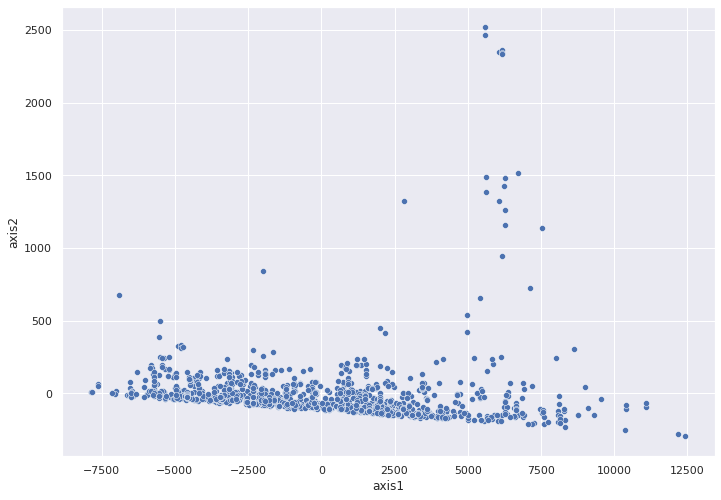

In [5]:
df = race[["distance","elevation_gain","elevation_loss","participants","aid_stations"]]

cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",data = X)

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

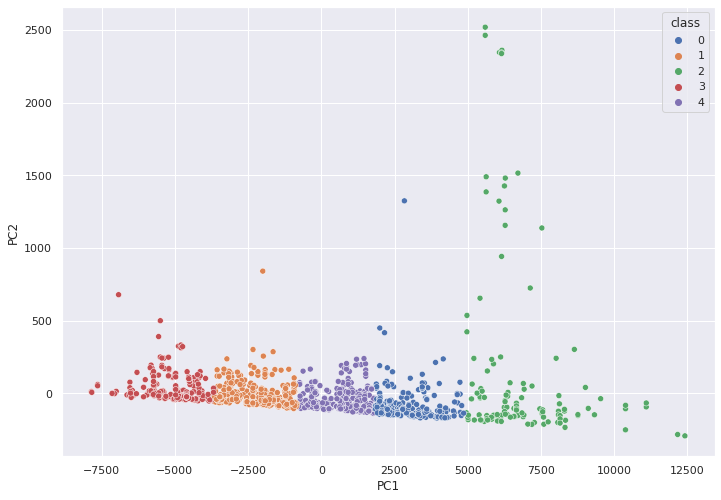

In [6]:
cls = KMeans(n_clusters=5, init="k-means++",n_init=100)
cls.fit(df)

scatterplot_pca(
    columns=["distance","elevation_gain","elevation_loss","participants","aid_stations"], hue=cls.labels_, data=df
)

In [7]:
unique_race = race.groupby(['race','event']).mean()
unique_race  = unique_race[['distance','elevation_gain','elevation_loss',"participants","aid_stations"]]
unique_race.reset_index()
unique_race_quant = unique_race[['distance','elevation_gain','elevation_loss',"participants","aid_stations"]]

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

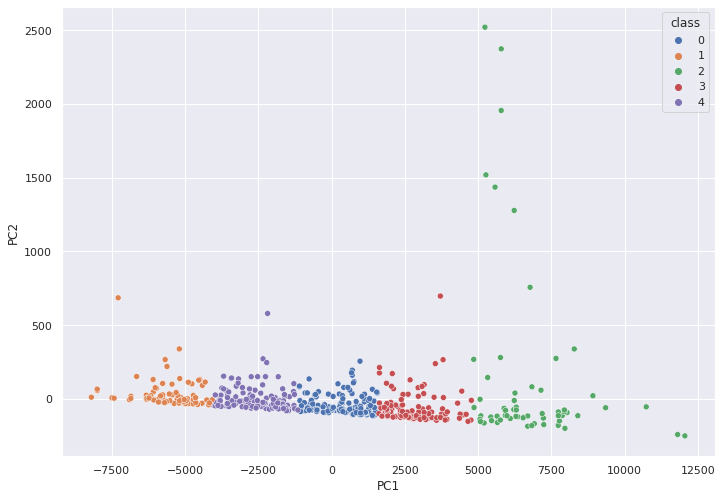

In [8]:
cls1 = KMeans(n_clusters=5, init="k-means++",n_init=100)
cls1.fit(unique_race_quant)

scatterplot_pca(
    columns=["distance","elevation_gain","elevation_loss","participants","aid_stations"], hue=cls1.labels_, data=unique_race_quant
)

In [9]:
one_hot_country = pd.get_dummies(race['country'], prefix = "country")
one_hot_participation = pd.get_dummies(race['participation'], prefix = "participation")
# Drop column B as it is now encoded
race = race.drop('country',axis = 1)
race = race.drop('participation',axis = 1)
# Join the encoded df
race = race.join(one_hot_country)
race = race.join(one_hot_participation)

In [10]:
df = race
df = df.drop(columns=['race_year_id','event','race','month'])

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

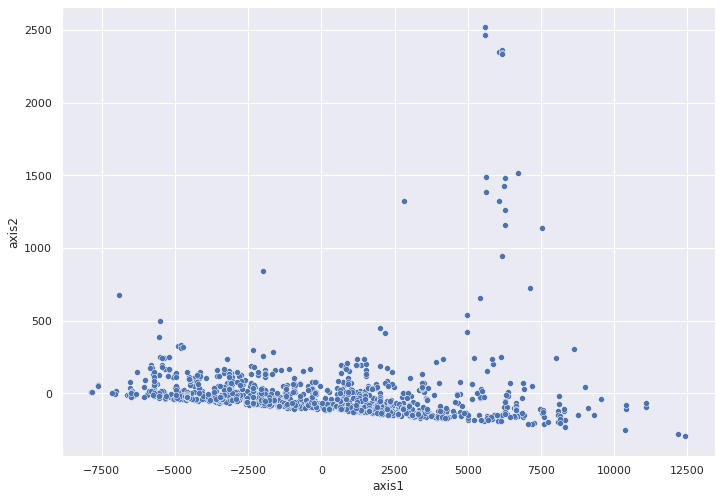

In [11]:
cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",data = X)

In [12]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

In [13]:
X = pd.DataFrame(
    squareform(pdist(df)),
    columns = df.index,
    index = df.index
)

In [14]:
X

,0,1,2,3,4,5,6,7,8,9,...,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206
0,0.000000,7796.781031,7733.589077,4207.434897,6250.862980,7537.814338,1329.421532,183.534738,2556.110326,2008.352867,...,2930.260536,312.838313,1301.360753,4921.533786,3648.756310,4130.488689,735.906794,2998.177248,3851.527984,4384.150979
1,7796.781031,0.000000,1073.362795,3744.654976,13983.816991,1480.423804,6497.773743,7615.043679,5300.731765,9778.441798,...,10667.450028,8100.259693,9075.470847,3117.876856,4279.420929,11864.755290,8521.339571,10754.319508,11571.754020,3586.511828
2,7733.589077,1073.362795,0.000000,3537.020073,13979.421212,444.866733,6406.835119,7554.782698,5183.940741,9740.297012,...,10653.414195,8043.677579,9032.515984,2833.937191,4097.102147,11856.038883,8468.453460,10728.377697,11570.717912,3362.559293
3,4207.434897,3744.654976,3537.020073,0.000000,10458.196967,3330.491377,2878.128913,4030.562245,1659.729499,6215.711954,...,7135.370138,4518.497759,5508.431537,715.313218,560.636246,8337.033705,4942.871332,7205.509073,8055.630702,177.983145
4,6250.862980,13983.816991,13979.421212,10458.196967,0.000000,13788.633181,7580.198032,6427.876399,8804.558024,4242.688586,...,3326.276929,5939.769121,4949.816684,11172.299683,9899.507059,2123.845147,5515.455395,3252.763780,2412.987611,10634.949610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4130.488689,11864.755290,11856.038883,8337.033705,2123.845147,11667.456844,5459.644479,4306.610316,6683.353381,2124.371975,...,1202.947214,3819.268909,2829.636549,9051.489822,7778.869327,0.000000,3395.621298,1134.888541,301.361909,8513.844431
1203,735.906794,8521.339571,8468.453460,4942.871332,5515.455395,8273.246957,2064.819566,914.092123,3290.942481,1273.205518,...,2196.195802,424.828201,566.006184,5656.855840,4384.069799,3395.621298,0.000000,2262.807548,3117.949807,5119.556914
1204,2998.177248,10754.319508,10728.377697,7205.509073,3252.763780,10535.936561,4327.509196,3175.298476,5552.386011,990.511126,...,145.141310,2687.102715,1697.137885,7919.610723,6646.822399,1134.888541,2262.807548,0.000000,870.221236,7382.225748
1205,3851.527984,11571.754020,11570.717912,8055.630702,2412.987611,11385.677591,5179.714359,4026.320331,6401.959185,1851.176191,...,922.145867,3540.310721,2552.304057,8770.404951,7498.201184,301.361909,3117.949807,870.221236,0.000000,8232.525979


In [15]:
n,p = X.shape
Qn = np.eye(n) - 1/n * np.ones((n,n),dtype=int)
Qp = np.eye(p) - 1/p * np.ones((p,p),dtype=int)

Xprime = Qn @ X @ Qp
Xprime

,0,1,2,3,4,5,6,7,8,9,...,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132
0,-2264.828508,2271.972008,2354.368833,1420.785492,-618.646356,2326.742811,-741.565241,-2037.542874,393.098459,-1153.178938,...,-857.004293,-2039.701417,-1463.872475,1707.201710,1136.873817,-668.166550,-1774.528845,-841.855035,-696.382175,1498.791783
1,2271.972008,-8784.789538,-7565.837964,-2301.974944,3854.327140,-6990.628238,1166.806454,2133.985553,-122.260617,3356.929478,...,3620.204684,2487.739448,3050.257104,-3356.435735,-1492.442078,3806.119537,2750.923417,3654.306711,3763.863346,-2558.827883
2,2354.368833,-7565.837964,-8493.611980,-2364.021068,3995.520140,-7880.596530,1221.456609,2219.313350,-93.462862,3464.373471,...,3751.757630,2576.746113,3152.891020,-3494.786622,-1529.172082,3942.991909,2843.626085,3773.953678,3908.416018,-2637.191639
3,1420.785492,-2301.974944,-2364.021068,-3308.470302,3066.866734,-2402.401048,285.321243,1287.663736,-1025.103265,2532.359251,...,2826.284411,1644.137132,2221.377412,-3020.839756,-2473.067144,3016.557569,1910.614795,2843.655893,2985.899646,-3229.196948
4,-618.646356,3854.327140,3995.520140,3066.866734,-11474.190164,3972.880826,904.530431,-397.882041,2036.865329,-3523.524047,...,-5065.668728,-1017.451437,-2420.097372,3353.286778,2782.943738,-7279.490919,-1599.661073,-5191.949330,-6739.603376,3144.909586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,-668.166550,3806.119537,3942.991909,3016.557569,-7279.490919,3922.558587,854.830975,-448.294027,1986.514783,-3570.986560,...,-5118.144345,-1067.097551,-2469.423409,3303.331015,2733.160103,-7332.481969,-1648.641072,-5238.970472,-6780.374980,3094.658505
1129,-1774.528845,2750.923417,2843.626085,1910.614795,-1599.661073,2816.568299,-251.774339,-1552.592620,882.323482,-2133.933419,...,-1836.676158,-2173.318661,-2444.834175,2196.916633,1626.580175,-1648.641072,-2756.042770,-1822.831866,-1675.567483,1988.590587
1130,-841.855035,3654.306711,3773.953678,2843.655893,-5191.949330,3749.661259,681.318648,-620.982911,1814.170369,-3746.224454,...,-5217.327293,-1240.640790,-2643.299118,3130.074871,2559.736131,-5238.970472,-1822.831866,-5415.236057,-5252.892697,2921.662778
1131,-696.382175,3763.863346,3908.416018,2985.899646,-6739.603376,3891.524414,825.645935,-477.838931,1955.865668,-3593.437265,...,-5148.200612,-1095.310660,-2496.010821,3272.991224,2703.237041,-6780.374980,-1675.567483,-5252.892697,-6830.991809,3064.085133


In [16]:
mds_Xprime = MDS(n_components=2, dissimilarity='precomputed')
aftd_Xprime = mds_Xprime.fit_transform(Xprime)

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

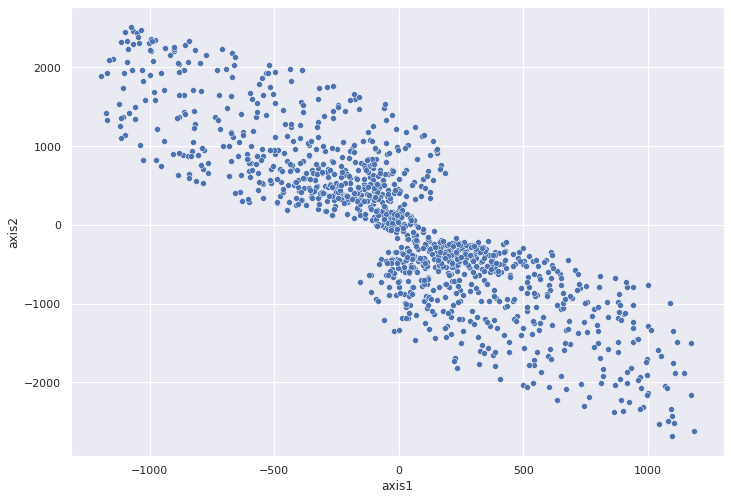

In [17]:
new_Xprime = pd.DataFrame(aftd_Xprime, columns=["axis1","axis2"])
sns.scatterplot(
    x = "axis1",
    y = "axis2",
    data = new_Xprime
)
#add_labels(new_Xprime.axis1, new_Xprime.axis2, new_Xprime.index)

In [18]:
def plot_Shepard(mds_model, plot=True):
    """Affiche le diagramme de Shepard et retourne un couple contenant les
    dissimilarités originales et les distances apprises par le
    modèle.
    """

    assert isinstance(mds_model, MDS)

    # Inter-distances apprises
    dist = cdist(mds_model.embedding_, mds_model.embedding_)
    idxs = np.tril_indices_from(dist, k=-1)
    dist_mds = dist[idxs]

    # Inter-distances d'origine
    dist = mds_model.dissimilarity_matrix_
    dist_orig = dist[idxs]

    dists = np.column_stack((dist_orig, dist_mds))

    if plot:
        f, ax = plt.subplots()
        range = [dists.min(), dists.max()]
        ax.plot(range, range, 'r--')
        ax.scatter(*dists.T)
        ax.set_xlabel('Dissimilarités')
        ax.set_ylabel('Distances')

    return (*dists.T,)

In [19]:
originals, learned = plot_Shepard(aftd)

NameError: name 'aftd' is not defined

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


In [ ]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean", distance_threshold=0, n_clusters=None)

In [ ]:
cls.fit(df)

In [ ]:
plot_dendrogram(cls)

In [20]:
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 71 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   race_year_id              1133 non-null   int64  
 1   event                     1133 non-null   object 
 2   race                      1133 non-null   object 
 3   distance                  1133 non-null   float64
 4   elevation_gain            1133 non-null   float64
 5   elevation_loss            1133 non-null   float64
 6   aid_stations              1133 non-null   int64  
 7   participants              1133 non-null   int64  
 8   year                      1133 non-null   int64  
 9   month                     1133 non-null   int64  
 10  day                       1133 non-null   int64  
 11  country_Andorra           1133 non-null   uint8  
 12  country_Argentina         1133 non-null   uint8  
 13  country_Australia         1133 non-null   uint8  
 14  country_

In [ ]:
race = race.assign()